In [4]:
# !env/bin/python3
''' Cobus Smit 2021
    started from 
    https://www.mattbutton.com/2019/01/24/how-to-scrape-yahoo-finance-and-extract-fundamental-stock-market-data-using-python-lxml-and-pandas/
    https://stackoverflow.com/questions/56528631/is-there-a-version-of-selenium-webdriver-that-is-not-detectable/56529616#56529616


'''
import os
import datetime
import time
import lxml
from lxml import html
import requests
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By


def get_page(url):
    # Set up the request headers that we're going to use, to simulate
    # a request by the Chrome browser. Simulating a request from a browser
    # is generally good practice when building a scraper
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cache-Control': 'max-age=0',
        'Pragma': 'no-cache',
        'Referrer': 'https://google.com',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
    }

    return requests.get(url, headers=headers)


def parse_rows(table_rows):
    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append(np.NaN)
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)

    return pd.DataFrame(parsed_rows)

def clean_data(df):
    df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
    df = df.transpose() # Transpose the DataFrame, so that our header contains the account names

    # Rename the "Breakdown" column to "Date"
    cols = list(df.columns)
    cols[0] = 'Date'
    df = df.set_axis(cols, axis='columns', inplace=False)

    numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Date' column)

    for column_index in range(1, len(df.columns)): # Take all columns, except the first (which is the 'Date' column)
        df.iloc[:,column_index] = df.iloc[:,column_index].str.replace(',', '') # Remove the thousands separator
        df.iloc[:,column_index] = df.iloc[:,column_index].astype(np.float64) # Convert the column to float64

    return df

def scrape_table(url):
    # Fetch the page that we're going to parse
    # Parse the page with LXML, so that we can start doing some XPATH queries
    # to extract the data that we want

    ## tree = html.fromstring( get_page(url).content )

    # Replace get_page[request] above with get_page_webdriver
    tree = html.fromstring( get_page_webdriver(url) )

    # Fetch all div elements which have class 'D(tbr)'
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]")

    # Ensure that some table rows are found; if none are found, then it's possible
    # that Yahoo Finance has changed their page layout, or have detected
    # that you're scraping the page.
    assert len(table_rows) > 0

    df = parse_rows(table_rows)
    df = clean_data(df)

    return df


def get_page_webdriver(url):
    tstart = time.time()
    options = webdriver.ChromeOptions() 
    options.add_argument("start-maximized")
    options.add_argument("--headless")
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)
    # Find path to chromedriver
    for fname in [ r'C:\Utility\BrowserDrivers\chromedriver.exe',
                   r'C:\Users\Killer\Desktop\Phyton\chromedriver.exe',
                   r'/usr/bin/chromedriver',
                 ]:
        if os.path.isfile(fname):
            browser = webdriver.Chrome(options=options, executable_path = fname)
            break
    else:
        print("Error in get_page_webdriver could not find chromedriver ?")
        exit(1)
    print(f"get_page_webdriver - loading {url}")
    browser.get(url)
    print(f"                   - scroll down ...", end="")
    browser.execute_script("window.scrollTo(0,300)")
    time.sleep(1)
    print(f" click expand ...", end="")
    click_expand = browser.find_element_by_xpath('//*[@id="Col1-1-Financials-Proxy"]/section/div[2]/button')
    click_expand.click()

    # Fetch the page that we're going to parse, using the request headers
    # defined above
    ## page = requests.get(url, headers)
    pageContent = browser.page_source
    print(f" got {len(pageContent):,} bytes in {time.time()-tstart:.1f}s.")
    
    # cleanurl = url.replace('/',"_").replace("?","_").replace(":","_")
    # browser.save_screenshot(f"debug-{datetime.today().strftime('%Y-%m-%d')}-{cleanurl}.png")
    
    return pageContent


def scrape(symbol):
    print('Attempting to scrape data for ' + symbol)

    df_balance_sheet = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/balance-sheet?p=' + symbol)
    df_balance_sheet = df_balance_sheet.set_index('Date')

    df_income_statement = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/financials?p=' + symbol)
    df_income_statement = df_income_statement.set_index('Date')

    df_cash_flow = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/cash-flow?p=' + symbol)
    df_cash_flow = df_cash_flow.set_index('Date')

    df_joined = df_balance_sheet \
        .join(df_income_statement, on='Date', how='outer', rsuffix=' - Income Statement') \
        .join(df_cash_flow, on='Date', how='outer', rsuffix=' - Cash Flow') \
        .dropna(axis=1, how='all') \
        .reset_index()
    df_joined.insert(1, 'Symbol', symbol)
    return df_joined


def scrape_multi(symbols):
    return pd.concat([scrape(symbol) for symbol in symbols], sort=False)

print("Loaded python functions.")


Loaded python functions.


In [7]:
''' Use functions above to retrieve stock symbols'''
symbols = ['KIO.JO', 'SOL.JO']
df_combined = scrape_multi(symbols)
df_combined


Attempting to scrape data for KIO.JO
get_page_webdriver - loading https://finance.yahoo.com/quote/KIO.JO/balance-sheet?p=KIO.JO
                   - scroll down ... click expand ... got 889,578 bytes in 17.5s.
get_page_webdriver - loading https://finance.yahoo.com/quote/KIO.JO/financials?p=KIO.JO
                   - scroll down ... click expand ... got 888,050 bytes in 18.0s.
get_page_webdriver - loading https://finance.yahoo.com/quote/KIO.JO/cash-flow?p=KIO.JO
                   - scroll down ... click expand ... got 842,784 bytes in 18.0s.
Attempting to scrape data for SOL.JO
get_page_webdriver - loading https://finance.yahoo.com/quote/SOL.JO/balance-sheet?p=SOL.JO
                   - scroll down ... click expand ... got 995,059 bytes in 18.3s.
get_page_webdriver - loading https://finance.yahoo.com/quote/SOL.JO/financials?p=SOL.JO
                   - scroll down ... click expand ... got 929,072 bytes in 19.9s.
get_page_webdriver - loading https://finance.yahoo.com/quote/SOL.JO/cas

,index,Symbol,Date,Total Assets,Current Assets,"Cash, Cash Equivalents & Short Term Investments",Cash And Cash Equivalents,Cash,Inventory,Raw Materials,...,Net Issuance Payments of Debt,Net Long Term Debt Issuance,Long Term Debt Issuance,Long Term Debt Payments,Net Short Term Debt Issuance,Short Term Debt Issuance,Short Term Debt Payments,Proceeds from Stock Option Exercised,Net Other Financing Charges,Other Cash Adjustment Outside Change in Cash
0,12/30/2019,KIO.JO,12/30/2019,66941000.0,22960000.0,12865000.0,12865000.0,12865000.0,5995000.0,1375000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12/30/2018,KIO.JO,12/30/2018,63051000.0,22078000.0,11670000.0,11670000.0,11670000.0,6236000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12/30/2017,KIO.JO,12/30/2017,62466000.0,21879000.0,13874000.0,13874000.0,13874000.0,4061000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,KIO.JO,ttm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,6/29/2020,SOL.JO,6/29/2020,479162000.0,177969000.0,35384000.0,34739000.0,NaN,27801000.0,11757000.0,...,25112000.0,6091000.0,36487000.0,-30396000.0,19021000.0,19998000.0,-977000.0,NaN,NaN,-1624000.0
1,6/29/2019,SOL.JO,6/29/2019,469968000.0,78015000.0,16507000.0,15877000.0,NaN,29646000.0,11768000.0,...,23131000.0,23884000.0,93884000.0,-70000000.0,-753000.0,977000.0,-1730000.0,NaN,NaN,-44000.0
2,6/29/2018,SOL.JO,6/29/2018,439235000.0,81257000.0,16769000.0,15148000.0,15148000.0,29364000.0,11337000.0,...,15112000.0,15762000.0,24961000.0,-9199000.0,-650000.0,1957000.0,-2607000.0,0.0,-725000.0,NaN
3,6/29/2017,SOL.JO,6/29/2017,398939000.0,87954000.0,30382000.0,27643000.0,27643000.0,25374000.0,10516000.0,...,9536000.0,6913000.0,9277000.0,-2364000.0,2623000.0,4033000.0,-1410000.0,0.0,-989000.0,NaN
4,NaN,SOL.JO,ttm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25112000.0,6091000.0,36487000.0,-30396000.0,19021000.0,19998000.0,-977000.0,NaN,NaN,-1624000.0


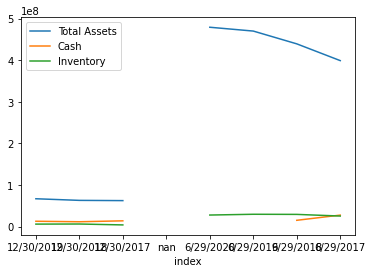

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
df_combined.plot(x="index", y=["Total Assets", "Cash", "Inventory"])
plt.show()

In [3]:
''' Write pandas dataframe to excel '''
date = datetime.today().strftime('%Y-%m-%d')
filename = f'Yahoo-Finance-Scrape2-{date}.xlsx'
writer = pd.ExcelWriter(filename)
df_combined.to_excel(writer)
writer.save()
print(f"The END. saved {filename}")

NameError: name 'datetime' is not defined